In [ ]:
# https://stackoverflow.com/questions/54613992/how-to-install-and-use-basemap-on-google-colab
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

In [1]:
!pip install pyproj==1.9.6

In [2]:
!pip install h5netcdf

In [3]:
import pyproj
import s3fs
import xarray as xr
import numpy as np

# Import dataset

In [4]:
fs_s3 = s3fs.S3FileSystem(anon=True, client_kwargs={
         'endpoint_url': 'https://s3.eu-de.cloud-object-storage.appdomain.cloud'
      })
s3path = 'greenlytics-public/MetNo_HIRES_MEPS_example.nc'
remote_file_obj = fs_s3.open(s3path, mode='rb')
ds = xr.open_dataset(remote_file_obj, engine='h5netcdf')

# Create projection
## This dataset uses a Lambert Conformal Conic projection 
## https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection

In [9]:
p = pyproj.Proj('+proj=lcc +lat_0=63 +lon_0=15 +lat_1=63 +lat_2=63 +no_defs +R=6.371e+06')

# Reverse-compute the latitudes and longitudes from x and y

In [10]:
x_list = np.array(ds.x.values.tolist() * len(ds.y.values))
y_list = np.array([[v] * len(ds.x.values) for v in ds.y.values]).flatten()
proj_longitudes, proj_latitudes = p(x_list, y_list, inverse=True)
proj_longitudes = np.reshape(proj_longitudes, (ds.y.shape[0], ds.x.shape[0]))
proj_latitudes = np.reshape(proj_latitudes, (ds.y.shape[0], ds.x.shape[0]))

# Make sure computed coordinates correspond to metadata

In [11]:
difference = np.absolute(ds.latitude.values - proj_latitudes)
print("Maximum difference between metadata latitudes " + 
      "and the ones computed from (x,y) values: {0}".format(np.max(difference)))
print(difference)

Maximum difference between metadata latitudes and the ones computed from (x,y) values: 2.842170943040401e-14
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.84217094e-14 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.42108547e-14
  0.00000000e+00 0.00000000e+00]
 [2.84217094e-14 0.00000000e+00 0.00000000e+00 ... 2.84217094e-14
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.84217094e-14 0.00000000e+00 ... 0.00000000e+00
  1.42108547e-14 0.00000000e+00]]


In [12]:
difference = np.absolute(ds.longitude.values - proj_longitudes)
print("Maximum difference between metadata longitudes " + 
      "and the ones computed from (x,y) values: {0}".format(np.max(difference)))
print(difference)

Maximum difference between metadata longitudes and the ones computed from (x,y) values: 2.842170943040401e-14
[[1.55431223e-15 1.55431223e-15 0.00000000e+00 ... 7.10542736e-15
  7.10542736e-15 1.06581410e-14]
 [1.77635684e-15 0.00000000e+00 1.55431223e-15 ... 7.10542736e-15
  7.10542736e-15 7.10542736e-15]
 [1.55431223e-15 1.55431223e-15 1.55431223e-15 ... 3.55271368e-15
  7.10542736e-15 7.10542736e-15]
 ...
 [1.06581410e-14 1.06581410e-14 1.42108547e-14 ... 2.13162821e-14
  1.42108547e-14 2.13162821e-14]
 [1.06581410e-14 1.24344979e-14 1.42108547e-14 ... 2.13162821e-14
  7.10542736e-15 2.13162821e-14]
 [1.42108547e-14 1.24344979e-14 8.88178420e-15 ... 1.42108547e-14
  2.84217094e-14 2.13162821e-14]]


In [13]:
print("Southernmost computed latitude: {0}".format(np.min(proj_latitudes)))
print("Southernmost metadata latitude: {0}".format(np.min(ds.latitude.values)))
print("Northernmost computed latitude: {0}".format(np.max(proj_latitudes)))
print("Northernmost metadata latitude: {0}".format(np.max(ds.latitude.values)))
print("Westernmost computed longitude: {0}".format(np.min(proj_longitudes)))
print("Westernmost metadata longitude: {0}".format(np.min(ds.longitude.values)))
print("Easternmost computed longitude: {0}".format(np.max(proj_longitudes)))
print("Easternmost metadata longitude: {0}".format(np.max(ds.longitude.values)))

Southernmost computed latitude: 52.302513128205455
Southernmost metadata latitude: 52.302513128205455
Northernmost computed latitude: 73.8591670304021
Northernmost metadata latitude: 73.85916703040213
Westernmost computed longitude: -11.761221129843415
Westernmost metadata longitude: -11.76122112984343
Easternmost computed longitude: 41.76428374316456
Easternmost metadata longitude: 41.76428374316458


# Plot a map of the area covered by the dataset

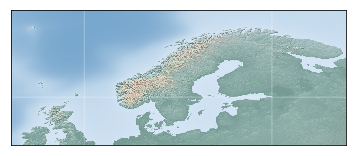

In [15]:
from itertools import chain
from mpl_toolkits.basemap import Basemap

def draw_map(m, scale=1):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')
        
m = Basemap(llcrnrlon=np.min(ds.longitude.values),
            llcrnrlat=np.min(ds.latitude.values),
            urcrnrlon=np.max(ds.longitude.values),
            urcrnrlat=np.max(ds.latitude.values), 
            resolution='i', 
            projection='cyl', 
            lon_0=15, 
            lat_0=63)

draw_map(m)